In [10]:
import numpy as np
import open3d as o3d
import cv2
import yaml

# Load plane coefficients
xyz_d0_means = np.load('xyz_d0_means.npy')
print("Loaded plane coefficients:", xyz_d0_means)

# Extract coefficients
a, b, c, d0 = xyz_d0_means
d0=-d0
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d0:.2f} = 0")

# Load camera parameters
with open('/media/hdd_4/PhD/T4/embedded system/fp/experiment1/camera_params.yaml', 'r') as f:
    camera_params = yaml.safe_load(f)

# Load RGB and depth images
rgb_path = '/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb_002000.png'
depth_path = '/media/hdd_4/PhD/T4/embedded system/fp/experiment1/depth/depth_002000.png'

rgb = cv2.imread(rgb_path)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)

# Create point cloud from depth image
def create_point_cloud(rgb, depth, camera_params):
    # Get camera parameters
    fx = camera_params['d435_depth']['fx']
    fy = camera_params['d435_depth']['fy']
    cx = camera_params['d435_depth']['cx']
    cy = camera_params['d435_depth']['cy']
    
    # Create meshgrid of pixel coordinates
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Convert to 3D points
    z = depth.astype(float) / 100.0  # Convert to meters
    x = (c - cx) * z / fx
    y = (r - cy) * z / fy
    
    # Stack coordinates and reshape
    points = np.stack([x, y, z], axis=-1)
    points = points.reshape(-1, 3)
    colors = rgb.reshape(-1, 3) / 255.0
    
    # Remove invalid points (where depth is 0)
    valid_points = z.reshape(-1) > 0
    points = points[valid_points]
    colors = colors[valid_points]
    
    return points, colors

# Create point cloud
points, colors = create_point_cloud(rgb, depth, camera_params)

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Create a mesh for the plane
def create_plane_mesh(coefficients, size=1.0):
    a, b, c, d0 = coefficients
    
    # Create a grid of points
    x = np.linspace(-size, size, 20)
    y = np.linspace(-size, size, 20)
    X, Y = np.meshgrid(x, y)
    
    # Calculate Z values for the plane (ax + by + cz + d0 = 0)
    Z = -(a*X + b*Y + d0) / c
    
    # Create vertices
    vertices = np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1)
    
    # Create triangles
    triangles = []
    for i in range(19):
        for j in range(19):
            v0 = i * 20 + j
            v1 = v0 + 1
            v2 = v0 + 20
            v3 = v2 + 1
            triangles.extend([[v0, v1, v2], [v1, v3, v2]])
    
    # Create mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()
    
    return mesh

# Create plane mesh
plane_mesh = create_plane_mesh(xyz_d0_means, size=2.0)  # Increased size to better see the plane
plane_mesh.paint_uniform_color([0, 1, 0])  # Green color for the plane

# Create coordinate frame
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1,  # Size of the coordinate frame
    origin=[0, 0, 0]  # Origin point
)

# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add geometries
vis.add_geometry(pcd)  # Add point cloud first
vis.add_geometry(plane_mesh)
vis.add_geometry(coordinate_frame)

# Set up camera
ctr = vis.get_view_control()
ctr.set_zoom(0.8)
ctr.set_front([0, 0, -1])
ctr.set_lookat([0, 0, 0])
ctr.set_up([0, -1, 0])

# Run visualization
vis.run()
vis.destroy_window()

Loaded plane coefficients: [ 0.03713292  0.7761131  -0.6294009   1.31044349]
Plane equation: 0.04x + 0.78y + -0.63z + -1.31 = 0


In [ ]:
import numpy as np
import open3d as o3d
import cv2
import yaml

# Load plane parameters
plane_mean = np.load('plane_mean.npy')
print("Loaded plane parameters:", plane_mean)

# Load camera parameters
with open('/media/hdd_4/PhD/T4/embedded system/fp/experiment1/camera_params.yaml', 'r') as f:
    camera_params = yaml.safe_load(f)

# Load RGB and depth images
rgb_path = '/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb002000.png'
depth_path = '/media/hdd_4/PhD/T4/embedded system/fp/experiment1/depth/depth_002000.png'

rgb = cv2.imread(rgb_path)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)

# Create point cloud from depth image
def create_point_cloud(rgb, depth, camera_params):
    # Get camera parameters (using depth camera parameters)
    fx = camera_params['d435_depth']['fx']
    fy = camera_params['d435_depth']['fy']
    cx = camera_params['d435_depth']['cx']
    cy = camera_params['d435_depth']['cy']
    
    # Create meshgrid of pixel coordinates
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Convert to 3D points
    z = depth.astype(float) / 1000.0  # Convert to meters
    x = (c - cx) * z / fx
    y = (r - cy) * z / fy
    
    # Stack coordinates and reshape
    points = np.stack([x, y, z], axis=-1)
    points = points.reshape(-1, 3)
    colors = rgb.reshape(-1, 3) / 255.0
    
    # Remove invalid points (where depth is 0)
    valid_points = z.reshape(-1) > 0
    points = points[valid_points]
    colors = colors[valid_points]
    
    return points, colors

# Create point cloud
points, colors = create_point_cloud(rgb, depth, camera_params)

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Create plane geometry
def create_plane_geometry(plane_params, size=2.0):
    # Extract plane parameters
    a, b, c = plane_params
    d = 0  # Assuming the plane passes through origin
    
    # Create a grid of points
    x = np.linspace(-size, size, 20)
    y = np.linspace(-size, size, 20)
    X, Y = np.meshgrid(x, y)
    
    # Calculate Z values
    Z = -(a*X + b*Y + d) / c
    
    # Create vertices
    vertices = np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1)
    
    # Create triangles
    triangles = []
    for i in range(19):
        for j in range(19):
            v0 = i * 20 + j
            v1 = v0 + 1
            v2 = v0 + 20
            v3 = v2 + 1
            triangles.extend([[v0, v1, v2], [v1, v3, v2]])
    
    # Create mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()
    
    return mesh

# Create and visualize plane
plane_mesh = create_plane_geometry(plane_mean)

# Create coordinate frame
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5,  # Size of the coordinate frame
    origin=[0, 0, 0]  # Origin point
)

# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add geometries
vis.add_geometry(pcd)
vis.add_geometry(plane_mesh)
vis.add_geometry(coordinate_frame)

# Set up camera
ctr = vis.get_view_control()
ctr.set_zoom(0.8)
ctr.set_front([0, 0, -1])
ctr.set_lookat([0, 0, 0])
ctr.set_up([0, -1, 0])

# Run visualization
vis.run()
vis.destroy_window()

Loaded plane parameters: [ 0.03713292  0.7761131  -0.6294009 ]


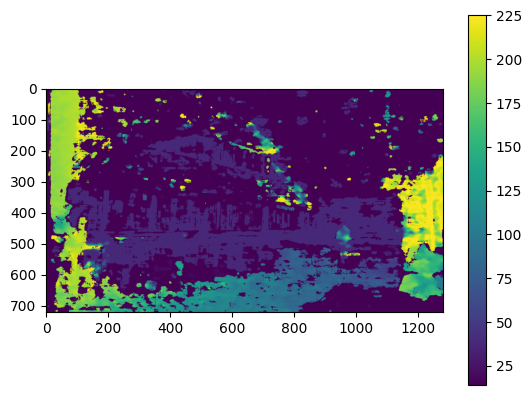

In [9]:
import matplotlib.pyplot as plt
plt.imshow(depth)
plt.colorbar()